CBRS

In [1]:
import pandas as pd
import numpy as np
import datetime as dtt

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from scipy.sparse import vstack

In [2]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "reviews_Video_Games_5.json"
N = 10

## Загружаем данные и формируем dataframe

In [3]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt))
        
    return pd.DataFrame(rows, columns=cols)

In [4]:
df = get_data_frame()
df.head()

,uid,iid,review,rating,dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400
2,2,0,1st shipment received a book instead of the ga...,1.0,1403913600
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600


## Pre-processing 

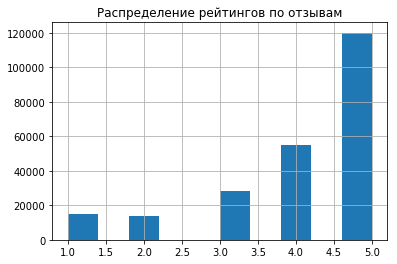

In [5]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist()

## Готовим выборки

In [21]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    
    а тестовая выборка - это последние 20% по времени, которая покажет купили ли юзеры или нет 
    
    """
    border_dt = df.dt.quantile(p)
    #print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    #print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    #print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [7]:
training_df, test_df = split_df_by_dt(df)
del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 5) (46353, 5)
Размер после очистки: (185427, 5) (19174, 5)


## Метрика

In [8]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...} уже есть 
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [9]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict

test_dict = get_test_dict(test_df)

In [10]:
uids = test_dict.keys() #  словарь ключей тестовой выборки  

## Class

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

class ContentBasedRS(object):
    
    def __init__(self, training_df):
        
        self.training_df = training_df
        self.iid_to_row, self.iid_ftr_m = self.prepare_iid_data() # словарь id item-ов # матрица item profile  
        self.uid_to_row, self.uid_ftr_m = self.prepare_uid_data() # словарь id user # матрица user profile
    
    # Создаем item profile 
    
    def prepare_iid_data(self): 
        
        iid_to_row = {} 
        rows = []
        
        # считаем TFIDDF 
        
        review_ftr_m = TfidfVectorizer(stop_words='english').fit_transform(self.training_df.review)
        # сразу умножаем на рейтинги TFIDF на рейтинг (переворачиваем строку рейтингов в колонку )
        review_ftr_m = review_ftr_m.multiply(self.training_df.rating.values.reshape(-1, 1)).tocsr()
        
        # делаем словарь и матрицу items 

        for row_id, iid in enumerate(self.training_df.iid.unique()):

            iid_to_row[iid] = row_id
            # делаем словарь соответствия идентификатор объекта номер строки в матрице объекта 
            iid_ftr_m = csr_matrix(review_ftr_m[np.where(self.training_df.iid == iid)[0]].sum(axis=0))
            rows.append(iid_ftr_m) # в итоге, получаем большое кол-во строк у каждой из которых 
            # строка эта матрица  - вектор у которого одна строка и много столбцов 
        
        iid_ftr_m = normalize(vstack(rows, format='csr'))
        
        return iid_to_row, iid_ftr_m
    
    
    # Создаем user profile
    
    def prepare_uid_data(self):  

        uid_to_row = {} # создаем словарь, где uid пользователя - ключ, а строка матрицы - значение 
        rows = [] # временное хранилище пользователя и фич 

        for gr_id, gr_df in self.training_df.groupby("uid"):

            uid = gr_id # делает тоже самое, что и у Турала uid = gr_df.uid.values[0], но проще
            iid_rows = [] # список объектов, которые уже оценили
            ratings = [] # какие рейтинги у каждого объекта, делаем из рейтинга список или строку (А)

            for iid, rating in zip (gr_df.iid.values, gr_df.rating.values):
                if iid in self.iid_to_row:
                    iid_rows.append(self.iid_to_row[iid])
                    ratings.append(rating)

            # создание профиля пользователя - матрицу user - фича 
            if iid_rows:
                ratings = np.array(ratings).reshape(-1, 1) # строку рейтингу превращаем в колонку, чтобы умножить  (Б)

                # создаем одномерную матрицу по каждому пользователю 
                uid_ftr_m = csr_matrix(
                    self.iid_ftr_m[iid_rows].multiply(ratings).sum(axis=0)
                ) 

                uid_to_row[uid] = len(uid_to_row) # делаем индекс - этот пользователь соответствует номер строки в матрице uid_ftr_m
                rows.append(uid_ftr_m) # добавляем одномерные матрицы в список
            
        #  создаем матрицу уже из списка строк, нормализуем данные 
        uid_ftr_m = normalize(vstack(rows, format='csr')) 

        return uid_to_row, uid_ftr_m

    # Создаем рекомендации для множества тестовых uids
    def get_recs1(self, uids, top=N):
        
        dic ={}
        # Т перворачивают матрицу для подсчета рекомендаций с использованием косинусной меры
        ftr_iid_m = self.iid_ftr_m.T.tocsr()
            
        # надо уметь возвращать из индекса строки в индекс объекта, чтобы рекомендации были в пространстве индексов объекта 
        row_to_iid = {row_id: iid for iid, row_id in self.iid_to_row.items()}
        
        for uid in list(uids):
            recs = {}
            if uid in self.uid_to_row:
                u_row_id = self.uid_to_row[uid] # номер строки в матрице пользователя - имя
                u_row = self.uid_ftr_m[u_row_id] # одномерная матрица профиля пользователя 
                # самописный cosine similarity
#                 u_recs = u_row.dot(self.ftr_iid_m)
                u_recs = u_row.dot(ftr_iid_m)

            # задача - умножить многомерную матрицу профилей пользователей
            # выделить строки uid test из большой матрица и умножить на профиля игр 

                for arg_id in np.argsort(u_recs.data)[-top:]: 
                # сортируем от маленьких к большим 
                    row_id = u_recs.indices[arg_id]
                    score = u_recs.data[arg_id]
                    recs[row_to_iid[row_id]] = score
            dic[uid] = recs
            # переводим номера  в названия 
        return dic

In [12]:
RS = ContentBasedRS(training_df)

In [13]:
%time
Recs = RS.get_recs1(uids, 10) 

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 35 µs


In [14]:
Recs

{2: {4825: 0.62541412399324969,
  5259: 0.64382736768690418,
  5262: 0.67136997718724345,
  5782: 0.68314120214612584,
  6426: 0.62341525247351215,
  6898: 0.73361199897898322,
  7071: 0.64992378067382417,
  7141: 0.68649486228695078,
  7208: 0.62772998415217085,
  7619: 0.70117727805468177},
 9: {3129: 0.63002812730646196,
  3860: 0.47982231916997603,
  3970: 0.61537257037880555,
  4509: 0.66640985424346,
  6324: 0.498229026103089,
  6338: 0.47559345935207564,
  6339: 0.48262130104498246,
  6585: 0.47154822612930392,
  6928: 0.48749868282865849,
  8382: 0.47134720731857266},
 12: {1090: 0.27408612753567341,
  3027: 0.33157044098457411,
  3918: 0.25320203832118632,
  4039: 0.31599541661149699,
  4364: 0.25371709270105541,
  6866: 0.25729303474110687,
  7463: 0.26054638870642682,
  7710: 0.27762769420213196,
  7990: 0.97178762331767699,
  8758: 0.29881719676824969},
 13: {2455: 0.5968133673565128,
  2603: 0.58422392344605878,
  3862: 0.58089515733261188,
  3872: 0.60895582518549418,
  5

In [16]:
hit_ratio(Recs, test_dict)

0.06500366837857667

In [18]:
def cross_validate(training_df, tries):

    training_df_cv = training_df.copy() # копируем тренинговую выборку 
    cv_scores = []
    
    for i in range(tries):
        training_df_cv, test_df_cv = split_df_by_dt(training_df_cv) 
        recommendations = RS.get_recs1(uids, 10)
        score = hit_ratio(recommendations, get_test_dict(test_df_cv))
        cv_scores.append(score)

    return cv_scores

In [23]:
cross_validate(training_df, 10)

[0.29877389109267943,
 0.19035269709543567,
 0.1304637971304638,
 0.09257518796992481,
 0.07326236693800876,
 0.05173807599029911,
 0.02617801047120419,
 0.016817593790426907,
 0.029216467463479414,
 0.02]